### Import Necessary Module and Set Path 

# Comparison of UNF-ST&DARDS database

## This notebook assesses the `value` of thte UNF-ST&DARDS database by comparing the results obtained with the full database (isotopic composition, etc) and the restuls obtained with using an average recipe (depletion calculations done with average enrichment and burnup).

## We used Cyclus, the agent-based fuel cycle simulator, to couple the UNF-ST&DARDS datbase to output UNF as defined by the database (time, composition, mass)

## The database used is the 1-year cooling data, which evaluated all UNF one year after its discharge from core. To be fair, we used the evaluation date of the assembly, which is when the isotopics are evaluated, not the discharge date.

## The average burnup and enrichment is listed below. The method to finding the average values are in `generate_avg_recipe.ipynb`.
* Burnup: 36,169.38 MWD/MTHM
* Enrichment: 3.392 % U-235


In [2]:
import sqlite3 as lite
import matplotlib.pyplot as plt
import os
from scipy import stats
import sys
import numpy as np
import collections
from pyne import nucname
from pyne.material import Material
sys.path.insert(0, '../../transition-scenarios/scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [3]:
import analysis as an

In [4]:
def annual_sum(timeseries):
    """ Annual sum timeseries"""
    output = np.zeros(len(timeseries) // 12)
    for i in range(len(timeseries)):
        if i // 12 == len(timeseries) // 12:
            continue
        output[i // 12] += timeseries[i]
    return output

# 1. Cyclus-coupled UNF-ST&DARDS

In [13]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('no_recipe.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)
monthly_step = init_year + timestep/12
yearly_step = np.arange(init_year, init_year + timestep[-1]/12, 1)[:-1]


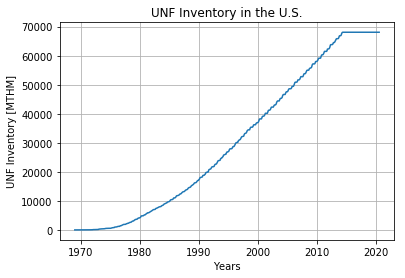

In [14]:
# Fuel Discharged - cumulative

reactors = an.get_agent_ids(cur, 'udb_reactor')
fuel_discharge_cum = an.facility_commodity_flux(cur, reactors, ['fuel'], True, True)
plt.plot(monthly_step, fuel_discharge_cum['fuel'])
plt.xlabel('Years')
plt.ylabel('UNF Inventory [MTHM]')
plt.title('UNF Inventory in the U.S.')
plt.grid()
plt.show()
plt.close()

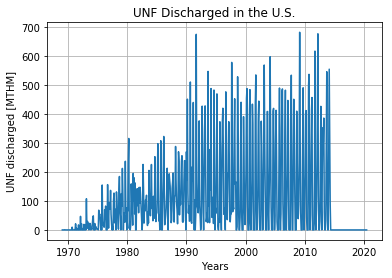

In [15]:
# Fuel Discharged - per timestep (month)

reactors = an.get_agent_ids(cur, 'udb_reactor')
fuel_discharge = an.facility_commodity_flux(cur, reactors, ['fuel'], True, False)
plt.plot(monthly_step, fuel_discharge['fuel'])
plt.xlabel('Years')
plt.ylabel('UNF discharged [MTHM]')
plt.title('UNF Discharged in the U.S.')
plt.grid()
plt.show()
plt.close()

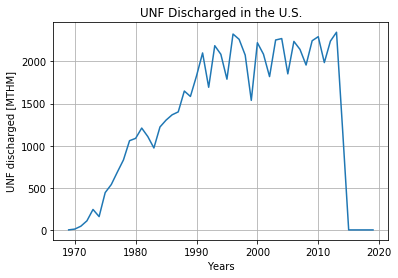

In [16]:
# Fuel Discharged - Annual sum
annual = annual_sum(fuel_discharge['fuel'])
plt.plot(yearly_step, annual)
plt.xlabel('Years')
plt.ylabel('UNF discharged [MTHM]')
plt.title('UNF Discharged in the U.S.')
plt.grid()
plt.show()
plt.close()

In [17]:
# get isotopics - this might take a while...
# Fuel Discharged - per timestep (month)

reactors = an.get_agent_ids(cur, 'udb_reactor')
iso_discharge = an.facility_commodity_flux_isotopics(cur, reactors, ['fuel'], True, False)
iso_discharge_cum = an.facility_commodity_flux_isotopics(cur, reactors, ['fuel'], True, True)

In [18]:
# how much of UNF is Pu-239?
frac = np.array(iso_discharge_cum['Pu239']) / np.array(fuel_discharge_cum['fuel'])
print('There is %f %% of Pu-239 in UNF' %stats.mode(frac)[0][0])

There is 0.007600 % of Pu-239 in UNF


/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


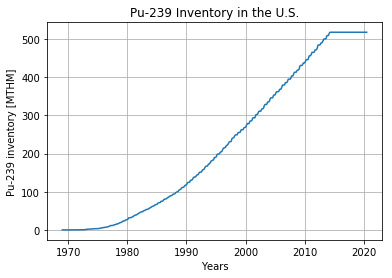

In [19]:
pu_239_buildup = iso_discharge_cum['Pu239']

plt.plot(monthly_step, pu_239_buildup)
plt.xlabel('Years')
plt.ylabel('Pu-239 inventory [MTHM]')
plt.title('Pu-239 Inventory in the U.S.')
plt.grid()
plt.show()
plt.close()

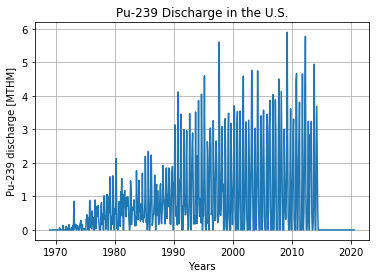

In [20]:
# since all compositions are the same, it follows 
pu_239_discharge = iso_discharge['Pu239']

plt.plot(monthly_step, pu_239_discharge)
plt.xlabel('Years')
plt.ylabel('Pu-239 discharge [MTHM]')
plt.title('Pu-239 Discharge in the U.S.')
plt.grid()
plt.show()
plt.close()

# CYCLUS DECAY

Cyclus has three decay modes - never, lazy, and manual (ref: http://fuelcycle.org/user/input_specs/control.html?highlight=control ).
* never: no decay at all.
* manual: decays material only when the facility archetype does it
* lazy: decays material when archetype / agents `look at` a composition (transactions)

I used the lazy decay, since this required no modification to the source code. To utilize it, I set up the simulation so that at the very last timestep (December of 2019), all the UNF in the storage facility is sent to a sink. Then, I look at the UNF composition in the sink.

In [21]:
# amount sent to sink at last timestep
sink_agentid = an.get_agent_ids(cur, 'sink')
total_unf_mass = cur.execute('SELECT quantity, qualid FROM transactions '
                             'INNER JOIN resources ON resources.resourceid = '
                             'transactions.resourceid WHERE receiverid = %s' %sink_agentid[0]).fetchall()
# only one transaction is made, thus we can use total_unf_mass[0]
print('TOTAL MASS AT THE END IS: %s MTHM' %total_unf_mass[0]['quantity'])

TOTAL MASS AT THE END IS: 68072030.3895958 MTHM


In [22]:
# get composition
composition = cur.execute('SELECT nucid, massfrac FROM compositions WHERE qualid = %s' %total_unf_mass[0]['qualid']).fetchall()
final_comp_dict = {}
for row in composition:
    iso_name = nucname.name(row['nucid'])
    massfrac = row['massfrac']
    final_comp_dict[iso_name] = massfrac

In [23]:
# multiply the composition by the massfrac
# unit in kg
cyclus_2020_dict = {}
for key, value in final_comp_dict.items():
    mass = total_unf_mass[0]['quantity'] * value
    cyclus_2020_dict[key] = float(mass)

print(sum(cyclus_2020_dict.values()))

68072030.3895958


In [24]:
# compare this with what UNF standard calculated for 2020
data_2020 = np.genfromtxt('../db/2020_comp.csv', delimiter=",", dtype=None)
data_2020_dict = {}
for data in data_2020:
    data_2020_dict[data[0].decode('utf-8').replace('-','')] = data[1]

print(sum(data_2020_dict.values()))

67984974.57236809


/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [25]:
# isotopic differenct percent:
def get_error_dict(data_comp_dict, comp_dict, percent=False):
    error_dict = {}
    norm_factor1 = 1
    norm_factor2 = 1
    if percent:
        norm_factor1 = sum(data_comp_dict.values())
        norm_factor2 = sum(comp_dict.values())
    for key, val in data_comp_dict.items():
        try:
            error = (val -comp_dict[key]) / val * 100
            error_dict[key] = error
        except:
            print('THIS KEY (%s) IS NOT IN CYCLUS OUTPUT' %key)
    return error_dict
        
avg_error_comp = get_error_dict(data_2020_dict, cyclus_2020_dict, True)
avg_error_mass = get_error_dict(data_2020_dict, cyclus_2020_dict)

print('\n========= COMP DIFF ============ \n')
for key, val in avg_error_comp.items():
    print('%s: %f %%' %(key, val))

print('\n========= MASS DIFF ============ \n')
for key, val in avg_error_mass.items():
    print('%s: %f kg' %(key, val))

THIS KEY (Ag108m) IS NOT IN CYCLUS OUTPUT
THIS KEY (Ag110m) IS NOT IN CYCLUS OUTPUT
THIS KEY (Am242m) IS NOT IN CYCLUS OUTPUT
THIS KEY (Ag108m) IS NOT IN CYCLUS OUTPUT
THIS KEY (Ag110m) IS NOT IN CYCLUS OUTPUT
THIS KEY (Am242m) IS NOT IN CYCLUS OUTPUT

========= COMP DIFF ============ 

Ac227: 0.202828 %
Am241: 0.229985 %
Am243: -0.007465 %
C14: -316.215672 %
Ce144: -3.778990 %
Cf249: 39.379601 %
Cf251: -0.005840 %
Cm242: -0.225693 %
Cm243: 0.009566 %
Cm244: -0.150100 %
Cm245: -0.004328 %
Cm246: -0.001483 %
Cm247: -0.003849 %
Cm248: 0.382511 %
Cs134: -1.269199 %
Cs135: 0.012463 %
Cs137: -0.114672 %
Eu152: 0.019260 %
Eu154: -0.392155 %
Eu155: -0.510519 %
H3: -0.229372 %
I129: -0.005516 %
Kr85: -0.120878 %
Nb94: -0.017502 %
Np237: 0.013149 %
Pa231: 0.117835 %
Pd107: -0.005907 %
Pm147: -1.005740 %
Pu238: -0.005746 %
Pu239: -0.004292 %
Pu240: -0.002995 %
Pu241: -0.420800 %
Pu242: -0.007905 %
Pu244: -0.016948 %
Ra226: 0.316101 %
Ru106: -0.776409 %
Sb125: -0.995289 %
Se79: -0.006091 %
Sm151:

In [27]:
# get decay heat
import math
def nansum(dict):
    val = 0
    for value in dict.values():
        # skip metastable isotopes
        if str(key)[-1] == '1':
            continue
        if math.isnan(value):
            continue
        else:
            val += value
    return val

def decay_heat(material, time=0):
    decayed = material.decay(time)
    heat = decayed.decay_heat()
    return nansum(heat)

def activity(material, time=0):
    decayed = Material.decay(material, time)
    act = decayed.activity()
    return nansum(act)

# pyne expects mass in grams
# decay heat in units of MW
# activity in Bq

material_cyc_avg = Material(cyclus_2020_dict)
material_data = Material(data_2020_dict)

cum_dict = {'cyc_avg': material_cyc_avg,
            'data': material_data}

print(activity(material_cyc_avg))
print(activity(material_data))
print('\n')
print(decay_heat(material_cyc_avg))
print(decay_heat(material_data))

6.033369882452349e+28
6.025558926924712e+28


15817345846.402504
15796748587.049852


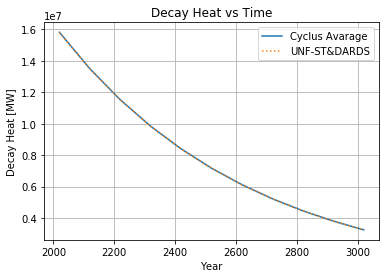

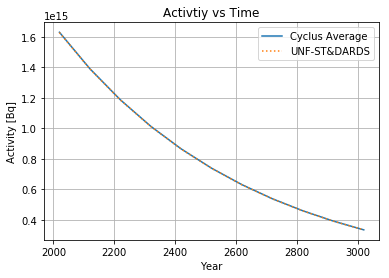

In [36]:
# decay profile over time,
years = np.arange(2020, 3100, 100)
secs_in_year = 3600 * 24 * 365
# t is in seconds
heat_cyc_avg = np.zeros(len(years))
act_cyc_avg = np.zeros(len(years))
heat_data = np.zeros(len(years))
act_data = np.zeros(len(years))

for indx, val in enumerate(years):
    heat_cyc_avg[indx] = decay_heat(material_cyc_avg, (val-2020)*secs_in_year) / 1000
    act_cyc_avg[indx] = activity(material_cyc_avg, (val-2020)*secs_in_year) / (1000 * 3.7e10)
    heat_data[indx] = decay_heat(material_data, (val-2020)*secs_in_year) / 1000
    act_data[indx] = activity(material_data, (val-2020)*secs_in_year) / (1000 * 3.7e10)
    
plt.plot(years, heat_cyc_avg, label='Cyclus Avarage')
plt.plot(years, heat_data, label='UNF-ST&DARDS', linestyle=':')
plt.ylabel('Decay Heat [MW]')
plt.xlabel('Year')
plt.grid()
plt.title('Decay Heat vs Time')
plt.legend()
plt.show()
plt.close()

plt.plot(years, act_cyc_avg, label='Cyclus Average')
plt.plot(years, act_data, label='UNF-ST&DARDS', linestyle=':')
plt.ylabel('Activity [Bq]')
plt.xlabel('Year')
plt.grid()
plt.title('Activtiy vs Time')
plt.legend()
plt.show()
plt.close()



In [59]:
# short lived vs long lived
# MA and non MA